# Occasionally binding constraint model - Solved with Adaptive Sparse Grids (Python)

This notebook solves the Bianchi (2011) model with occasionally binding collateral constraints using Adaptive Sparse Grids

## Setup: Path Configuration

This cell ensures the DDSG module can be imported from the local directory.


In [1]:
# Setup Python path to find DDSG module
import sys
import os

# Try to find DDSG folder in common locations
ddsg_paths = [
    './DDSG',           # Same directory as notebook
    '../DDSG',          # Parent directory
    '../../HDMR/DDSG',  # Original location
]

ddsg_found = False
for path in ddsg_paths:
    if os.path.exists(path):
        abs_path = os.path.abspath(path)
        if abs_path not in sys.path:
            sys.path.insert(0, os.path.dirname(abs_path))
        print(f"Found DDSG at: {abs_path}")
        ddsg_found = True
        break

if not ddsg_found:
    print("Warning: DDSG folder not found. Please ensure it's in the same directory as this notebook.")
    print(f"Current directory: {os.getcwd()}")
    print(f"Searched locations: {ddsg_paths}")


Found DDSG at: /home/tdtulo/Desktop/HDDP_github/high_dim_DP/notebooks/DDSG


## Install Dependencies

The DDSG module requires:
- `mpi4py`: MPI for Python (parallel computing)
- `Tasmanian`: Toolkit for Adaptive Stochastic Modeling and Non-Intrusive Approximation
- `quantecon`: Quantitative Economics tools
- `scipy`, `numpy`, `matplotlib`, `tabulate`

**Note:** Installing Tasmanian can be complex. If you encounter issues, see: https://tasmanian.ornl.gov/


In [2]:
# Install required packages on Ubuntu/Debian systems
# Run these commands in your terminal (outside Jupyter):

# sudo apt-get update
# sudo apt-get install python3-mpi4py python3-quantecon python3-scipy python3-numpy python3-matplotlib

# For Tasmanian (more complex):
# Option 1: Install via conda (recommended if you use conda)
# conda install -c conda-forge tasmanian

# Option 2: Build from source
# git clone https://github.com/ORNL/TASMANIAN.git
# cd TASMANIAN
# mkdir build && cd build
# cmake -DCMAKE_INSTALL_PREFIX=/usr/local ..
# make
# sudo make install

# Verify installations:
try:
    import mpi4py
    print('✓ mpi4py installed')
except ImportError:
    print('✗ mpi4py not found - run: sudo apt-get install python3-mpi4py')

try:
    import Tasmanian
    print('✓ Tasmanian installed')
except ImportError:
    print('✗ Tasmanian not found - see installation options above')

try:
    import quantecon
    print('✓ quantecon installed')
except ImportError:
    print('✗ quantecon not found - run: sudo apt-get install python3-quantecon')

try:
    import scipy
    print('✓ scipy installed')
except ImportError:
    print('✗ scipy not found - run: sudo apt-get install python3-scipy')


✓ mpi4py installed
✓ Tasmanian installed
✓ quantecon installed
✓ scipy installed


## Model Setup and Calibration

In [3]:
# %%
"""
Bianchi (2011) Sudden Stops Model solved using DDSG/Adaptive Sparse Grids
Time Iteration Method

This implementation follows the DDSG framework from the HDMR library,
adapted for the Bianchi sudden stops model with occasionally binding constraints.

Based on calibration from: Sudden stops and optimal foreign exchange intervention (Davis et al, 2023)
"""

import numpy as np
import sys
import os
import time
from scipy import optimize
from tabulate import tabulate
import matplotlib.pyplot as plt

# Add DDSG to path (works in Jupyter notebooks)
import os
if os.path.exists('./DDSG'):
    sys.path.insert(0, './DDSG')
elif os.path.exists('../DDSG'):
    sys.path.insert(0, '../DDSG')
else:
    print("Warning: DDSG folder not found in current or parent directory")

from DDSG import DDSG #tasmanian wrapper
from quantecon.markov import tauchen



In [5]:
class BianchiModel:
    """
    Bianchi (2011) Sudden Stops Model

    State variables: (l, yT) - current debt level and traded goods income
    Policy variables: (l', mu) - next period debt and Lagrange multiplier on borrowing constraint
    """

    def __init__(self):
        """Initialize the Bianchi model"""

        # Structural parameters
        self.sigma = 2           # Inverse of intertemporal elasticity of consumption
        self.kappa = 0.2808      # Parameter in borrowing constraint
        self.beta = 0.91         # Subjective discount factor
        self.omega = 0.31        # Weight on traded goods in CES aggregator
        self.eta = 0.5           # Elasticity of substitution between traded/non-traded goods
        self.tau = 0.2           # Government default cost
        self.i_l = 0.05          # Interest rate
        self.yN = 1.0            # Endowment of non-traded goods

        # Income process parameters
        self.rho_y = 0.945       # Persistence in the income process
        self.eta_y = 0.025       # Standard deviation of the income process
        self.yT_size = 5         # Grid size for income

        # Discretize income process using Tauchen
        mc = tauchen(self.yT_size, self.rho_y, self.eta_y, 0, 1.5)
        self.yT_grid = np.exp(mc.state_values)
        self.Pi = mc.P  # Transition matrix
        self.n_s = self.yT_size

        # Debt grid parameters
        self.l_min = 0.0
        self.l_max = 0.85
        self.NDL = np.min(self.yT_grid * (1 - self.tau)) / self.i_l  # Natural debt limit

        # Grid dimensions
        self.grid_dim = 2  # (l, yT)
        self.grid_dof = 2  # (l', mu)

        # Flags
        self.flag_set_integral = False

    def set_integral_rule(self):
        """
        Set up numerical integration for expectations
        Using the transition matrix from the Tauchen discretization
        """
        self.integral_weights = self.Pi
        self.flag_set_integral = True

    def print_parameters(self):
        """Print model parameters"""
        H = ['Parameter', 'Variable', 'Value']
        T = []
        T.append(['Inverse IES', 'sigma', self.sigma])
        T.append(['Borrowing constraint parameter', 'kappa', self.kappa])
        T.append(['Discount factor', 'beta', self.beta])
        T.append(['Weight on traded goods', 'omega', self.omega])
        T.append(['Elasticity of substitution', 'eta', self.eta])
        T.append(['Default cost', 'tau', self.tau])
        T.append(['Interest rate', 'i_l', self.i_l])
        T.append(['Non-traded endowment', 'yN', self.yN])
        T.append(['Income persistence', 'rho_y', self.rho_y])
        T.append(['Income std dev', 'eta_y', self.eta_y])
        T.append(['Income grid size', 'yT_size', self.yT_size])
        T.append(['Debt range', '[l_min, l_max]', f'[{self.l_min:.3f}, {self.l_max:.3f}]'])
        T.append(['Natural debt limit', 'NDL', f'{self.NDL:.3f}'])

        print(tabulate(T, headers=H))

    def dudcT(self, ct, yn=None):
        """Marginal utility of traded consumption"""
        if yn is None:
            yn = self.yN
        if ct > 0:
            return self.omega * ct**(-1/self.eta) * \
                   (self.omega * ct**((self.eta-1)/self.eta) +
                    (1-self.omega) * yn**((self.eta-1)/self.eta))**((1 - self.sigma*self.eta)/(self.eta-1))
        else:
            return 1e10

    def price_nontradable(self, ct, yn=None):
        """Price of non-tradable goods"""
        if yn is None:
            yn = self.yN
        return (1 - self.omega) / self.omega * (np.maximum(ct, 1e-9) / yn)**(1 / self.eta)

    def borrowing_constraint(self, ct, yT):
        """Borrowing constraint limit"""
        pn = self.price_nontradable(ct)
        return self.kappa * (pn * self.yN + yT * (1 - self.tau))

    def system_of_equations(self, x, state, p_last):
        """
        System of equilibrium equations for the Bianchi model

        Args:
            x: Policy variables [l', mu]
            state: State variables [l, yT]
            p_last: Previous policy function (DDSG object)

        Returns:
            Residuals of the FOCs
        """
        l_current = state[0]
        yT_current = state[1]

        l_next = x[0]
        mu = x[1]

        # Current consumption
        ct = yT_current * (1 - self.tau) - l_current + l_next / (1 + self.i_l)
        ct = max(ct, 1e-9)

        # Current marginal utility
        lambda_current = self.dudcT(ct, self.yN)

        # Borrowing constraint
        bc = self.borrowing_constraint(ct, yT_current)

        # Expected marginal utility next period
        # We need to integrate over possible yT' states
        E_lambda_next = 0.0

        # Find index in yT_grid closest to current yT
        yT_idx = np.argmin(np.abs(self.yT_grid - yT_current))

        for s_next in range(self.n_s):
            yT_next = self.yT_grid[s_next]
            state_next = np.array([l_next, yT_next]).reshape(1, -1)

            # Get next period policy
            policy_next = p_last.eval(state_next).flatten()
            l_next_next = policy_next[0]

            # Next period consumption
            ct_next = yT_next * (1 - self.tau) - l_next + l_next_next / (1 + self.i_l)
            ct_next = max(ct_next, 1e-9)

            # Next period marginal utility
            lambda_next = self.dudcT(ct_next, self.yN)

            # Add to expectation
            E_lambda_next += self.Pi[yT_idx, s_next] * lambda_next

        # Euler equation residual
        euler_res = lambda_current / (1 + self.i_l) - self.beta * E_lambda_next - mu

        # Complementarity condition: mu >= 0, l' <= bc, mu(bc - l') = 0
        # We use: min(mu, bc - l') = 0
        complementarity_res = min(mu, bc - l_next)

        return np.array([euler_res, complementarity_res])

## DDSG Solver Implementation

In [6]:
def solve_bianchi_ddsg():
    """
    Main function to solve the Bianchi model using DDSG and time iteration
    """

    print("="*80)
    print("Solving Bianchi (2011) Sudden Stops Model with DDSG")
    print("="*80)

    # Initialize model
    model = BianchiModel()
    model.set_integral_rule()
    model.print_parameters()

    print("\n" + "="*80)
    print("Setting up DDSG grid and time iteration")
    print("="*80)

    # Grid domain parameters
    domain = np.zeros((model.grid_dim, 2))
    domain[0, 0] = model.l_min  # l_min
    domain[0, 1] = model.l_max  # l_max
    domain[1, 0] = np.min(model.yT_grid)  # yT_min
    domain[1, 1] = np.max(model.yT_grid)  # yT_max

    print(f"\nGrid domain:")
    print(f"  Debt (l): [{domain[0,0]:.3f}, {domain[0,1]:.3f}]")
    print(f"  Income (yT): [{domain[1,0]:.3f}, {domain[1,1]:.3f}]")

    # Initial guess function
    def eq_condition_init_guess(X):
        """Initial guess for policy function"""
        n, d = X.shape
        val = np.empty(shape=(n, model.grid_dof))
        for i in range(n):
            l_state = X[i, 0]
            yT_state = X[i, 1]
            # Simple guess: borrow up to 80% of current debt, zero multiplier
            val[i, 0] = 0.8 * l_state  # l'
            val[i, 1] = 0.0  # mu
        return val

    # Equilibrium condition function for DDSG
    def eq_condition(X):
        """Solve for equilibrium policies at each grid point"""
        global p_last
        n, d = X.shape
        result = np.empty(shape=(n, model.grid_dof))

        for i in range(n):
            state = X[i, :]
            l_state = state[0]
            yT_state = state[1]

            # Get initial guess from previous policy
            p_guess = p_last.eval(X[i, :].reshape(1, -1)).flatten()

            # Ensure non-negative multiplier
            p_guess[1] = max(p_guess[1], 0.0)

            # Solve system of equations
            try:
                solution = optimize.root(
                    fun=model.system_of_equations,
                    x0=p_guess,
                    args=(state, p_last),
                    method='hybr',
                    tol=1e-6
                )

                if solution.success:
                    result[i, 0] = solution.x[0]  # l'
                    result[i, 1] = max(solution.x[1], 0.0)  # mu (enforce non-negativity)
                else:
                    # If solver fails, use guess
                    result[i, 0] = p_guess[0]
                    result[i, 1] = max(p_guess[1], 0.0)

            except Exception as e:
                # Fallback to guess if optimization fails
                result[i, 0] = p_guess[0]
                result[i, 1] = max(p_guess[1], 0.0)

        return result

    # ============================================================================
    # Stage 1: Coarse time-iteration to get baseline
    # ============================================================================
    print("\n" + "-"*80)
    print("Stage 1: Coarse time-iteration (baseline)")
    print("-"*80)

    iter_max_baseline = 100
    l_max_baseline = 1
    eps_sg_baseline = 0

    # Construct initial grid with guessed policy
    global p_last
    p_last = DDSG()
    p_last.init(f_orical=eq_condition_init_guess, d=model.grid_dim, m=model.grid_dof)
    p_last.set_grid(domain=domain, l_max=l_max_baseline, eps_sg=eps_sg_baseline)
    p_last.build(verbose=0)

    print(f"\nStarting coarse time-iteration (max {iter_max_baseline} iterations)...")

    for i in range(iter_max_baseline):
        p_next = DDSG()
        p_next.init(eq_condition, d=model.grid_dim, m=model.grid_dof)
        p_next.set_grid(domain=domain, l_max=l_max_baseline, eps_sg=eps_sg_baseline)
        p_next.build(verbose=0)

        if i % 10 == 0:
            print(f'  Iteration {i}')

        # Swap policy
        p_last = p_next

    print(f"\nBaseline complete after {iter_max_baseline} iterations")
    print(f"Grid points: {p_last.num_grid_points}")

    # Save baseline
    p_next.dump('p_bianchi_baseline', replace=True)

    # ============================================================================
    # Stage 2: Adaptive SG refinement
    # ============================================================================
    print("\n" + "-"*80)
    print("Stage 2: Adaptive Sparse Grid refinement")
    print("-"*80)

    iter_max_sg = 23
    l_max_sg = 10
    eps_sg = 1e-2 #adds points where the error is greater than eps_sg

    # Sample points for convergence check
    np.random.seed(42)
    X_sample = np.random.uniform(
        low=domain[:, 0],
        high=domain[:, 1],
        size=(500, model.grid_dim)
    )

    # Results tracking
    t_total_sg = []
    grid_points_sg = []
    error_l2_mean_sg = []

    # Load baseline
    p_last = DDSG('p_bianchi_baseline')

    print(f"\nRefining with adaptive SG (max {iter_max_sg} iterations)...")
    print(f"Parameters: l_max={l_max_sg}, eps_sg={eps_sg:.2e}")

    for i in range(iter_max_sg):
        t_total_sg.append(-time.time())

        p_next = DDSG()
        p_next.init(eq_condition, d=model.grid_dim, m=model.grid_dof)
        p_next.set_grid(domain=domain, l_max=l_max_sg, eps_sg=eps_sg)
        p_next.build(verbose=0)

        t_total_sg[-1] += time.time()

        # Compute error
        diff = p_next.eval(X_sample) - p_last.eval(X_sample)
        error_l2_mean_sg.append(np.linalg.norm(diff.flatten()) / diff.size)
        grid_points_sg.append(p_next.num_grid_points)

        print(f'  Iteration {i}: time={t_total_sg[-1]:.2f}s, '
              f'L2 error={error_l2_mean_sg[-1]:.2e}, '
              f'grid points={grid_points_sg[-1]}')

        # Check convergence
        if i > 0 and error_l2_mean_sg[-1] < 1e-5:
            print(f"\n  Converged at iteration {i}!")
            break

        # Swap policy
        p_last = p_next

    # Save final policy
    p_next.dump('p_bianchi_sg', replace=True)

    print("\n" + "="*80)
    print("Solution complete!")
    print("="*80)
    print(f"Final grid points: {p_next.num_grid_points}")
    print(f"Total time: {sum(t_total_sg):.2f}s")

    # ============================================================================
    # Visualization
    # ============================================================================
    print("\n" + "-"*80)
    print("Generating plots...")
    print("-"*80)

    # Extract grid points from the sparse grid
    X_grid, Y_grid = p_next.get_points_values()
    print(f"  Grid points extracted: {X_grid.shape[0]}")

    # Create grid for plotting
    l_plot = np.linspace(model.l_min, model.l_max, 100)
    yT_plot_idx = model.n_s // 2  # Middle income state
    yT_plot = model.yT_grid[yT_plot_idx]

    X_plot = np.column_stack([l_plot, np.full_like(l_plot, yT_plot)])
    policy_plot = p_next.eval(X_plot)

    # Create figure with 3x2 subplots
    fig = plt.figure(figsize=(14, 15))

    # Policy function l'(l, yT)
    ax = plt.subplot(3, 2, 1)
    for s_idx in range(model.n_s):
        yT_val = model.yT_grid[s_idx]
        X_temp = np.column_stack([l_plot, np.full_like(l_plot, yT_val)])
        policy_temp = p_next.eval(X_temp)
        ax.plot(l_plot, policy_temp[:, 0], label=f'yT={yT_val:.3f}')
    ax.plot(l_plot, l_plot, '--', color='black', alpha=0.5, label='45 degree line')
    ax.set_xlabel('Current debt (l)')
    ax.set_ylabel("Next period debt (l')")
    ax.set_title("Policy Function l'(l, yT)")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Lagrange multiplier mu(l, yT)
    ax = plt.subplot(3, 2, 2)
    for s_idx in range(model.n_s):
        yT_val = model.yT_grid[s_idx]
        X_temp = np.column_stack([l_plot, np.full_like(l_plot, yT_val)])
        policy_temp = p_next.eval(X_temp)
        ax.plot(l_plot, policy_temp[:, 1], label=f'yT={yT_val:.3f}')
    ax.axhline(0, linestyle='--', color='black', alpha=0.5)
    ax.set_xlabel('Current debt (l)')
    ax.set_ylabel('Lagrange multiplier (mu)')
    ax.set_title('Lagrange Multiplier mu(l, yT)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Sparse Grid Points Allocation in State Space
    ax = plt.subplot(3, 2, 3)
    scatter = ax.scatter(X_grid[:, 0], X_grid[:, 1], c=Y_grid[:, 1],
                        s=20, alpha=0.6, cmap='viridis', edgecolors='black', linewidths=0.5)
    ax.set_xlabel('Debt (l)')
    ax.set_ylabel('Income (yT)')
    ax.set_title(f'Sparse Grid Points (n={X_grid.shape[0]})')
    ax.set_xlim([domain[0, 0], domain[0, 1]])
    ax.set_ylim([domain[1, 0], domain[1, 1]])
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Multiplier (mu)', rotation=270, labelpad=15)
    ax.grid(True, alpha=0.3)

    # Grid points colored by debt policy
    ax = plt.subplot(3, 2, 4)
    scatter2 = ax.scatter(X_grid[:, 0], X_grid[:, 1], c=Y_grid[:, 0],
                         s=20, alpha=0.6, cmap='coolwarm', edgecolors='black', linewidths=0.5)
    ax.set_xlabel('Debt (l)')
    ax.set_ylabel('Income (yT)')
    ax.set_title(f'Sparse Grid Points colored by l\'')
    ax.set_xlim([domain[0, 0], domain[0, 1]])
    ax.set_ylim([domain[1, 0], domain[1, 1]])
    cbar2 = plt.colorbar(scatter2, ax=ax)
    cbar2.set_label("Next debt (l')", rotation=270, labelpad=15)
    ax.grid(True, alpha=0.3)

    # Convergence: L2 error vs iterations
    ax = plt.subplot(3, 2, 5)
    ax.plot(range(len(error_l2_mean_sg)), error_l2_mean_sg, '-o', color='blue')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('L2 Error')
    ax.set_title('Convergence: L2 Error')
    ax.grid(True, which='both', alpha=0.3)

    # Convergence: time vs grid points
    ax = plt.subplot(3, 2, 6)
    ax.plot(np.cumsum(grid_points_sg), error_l2_mean_sg, '-o', color='green')
    ax.set_yscale('log')
    ax.set_xlabel('Cumulative Grid Points')
    ax.set_ylabel('L2 Error')
    ax.set_title('Convergence: Error vs Grid Points')
    ax.grid(True, which='both', alpha=0.3)

    plt.tight_layout()
    plt.savefig('bianchi_ddsg_solution.png', dpi=150)
    print("  Saved plot to: bianchi_ddsg_solution.png")
    plt.show()

    # ============================================================================
    # Summary statistics
    # ============================================================================
    print("\n" + "="*80)
    print("Summary Statistics")
    print("="*80)

    summary_data = []
    summary_data.append(['Final grid points', grid_points_sg[-1]])
    summary_data.append(['Final L2 error', f'{error_l2_mean_sg[-1]:.2e}'])
    summary_data.append(['Total iterations', len(error_l2_mean_sg)])
    summary_data.append(['Total time (s)', f'{sum(t_total_sg):.2f}'])
    summary_data.append(['Avg time per iter (s)', f'{np.mean(t_total_sg):.2f}'])

    print(tabulate(summary_data, headers=['Metric', 'Value']))

    return p_next, model


## Execution and Results

Solving Bianchi (2011) Sudden Stops Model with DDSG
Parameter                       Variable        Value
------------------------------  --------------  --------------
Inverse IES                     sigma           2
Borrowing constraint parameter  kappa           0.2808
Discount factor                 beta            0.91
Weight on traded goods          omega           0.31
Elasticity of substitution      eta             0.5
Default cost                    tau             0.2
Interest rate                   i_l             0.05
Non-traded endowment            yN              1.0
Income persistence              rho_y           0.945
Income std dev                  eta_y           0.025
Income grid size                yT_size         5
Debt range                      [l_min, l_max]  [0.000, 0.850]
Natural debt limit              NDL             14.267

Setting up DDSG grid and time iteration

Grid domain:
  Debt (l): [0.000, 0.850]
  Income (yT): [0.892, 1.121]

----------------------

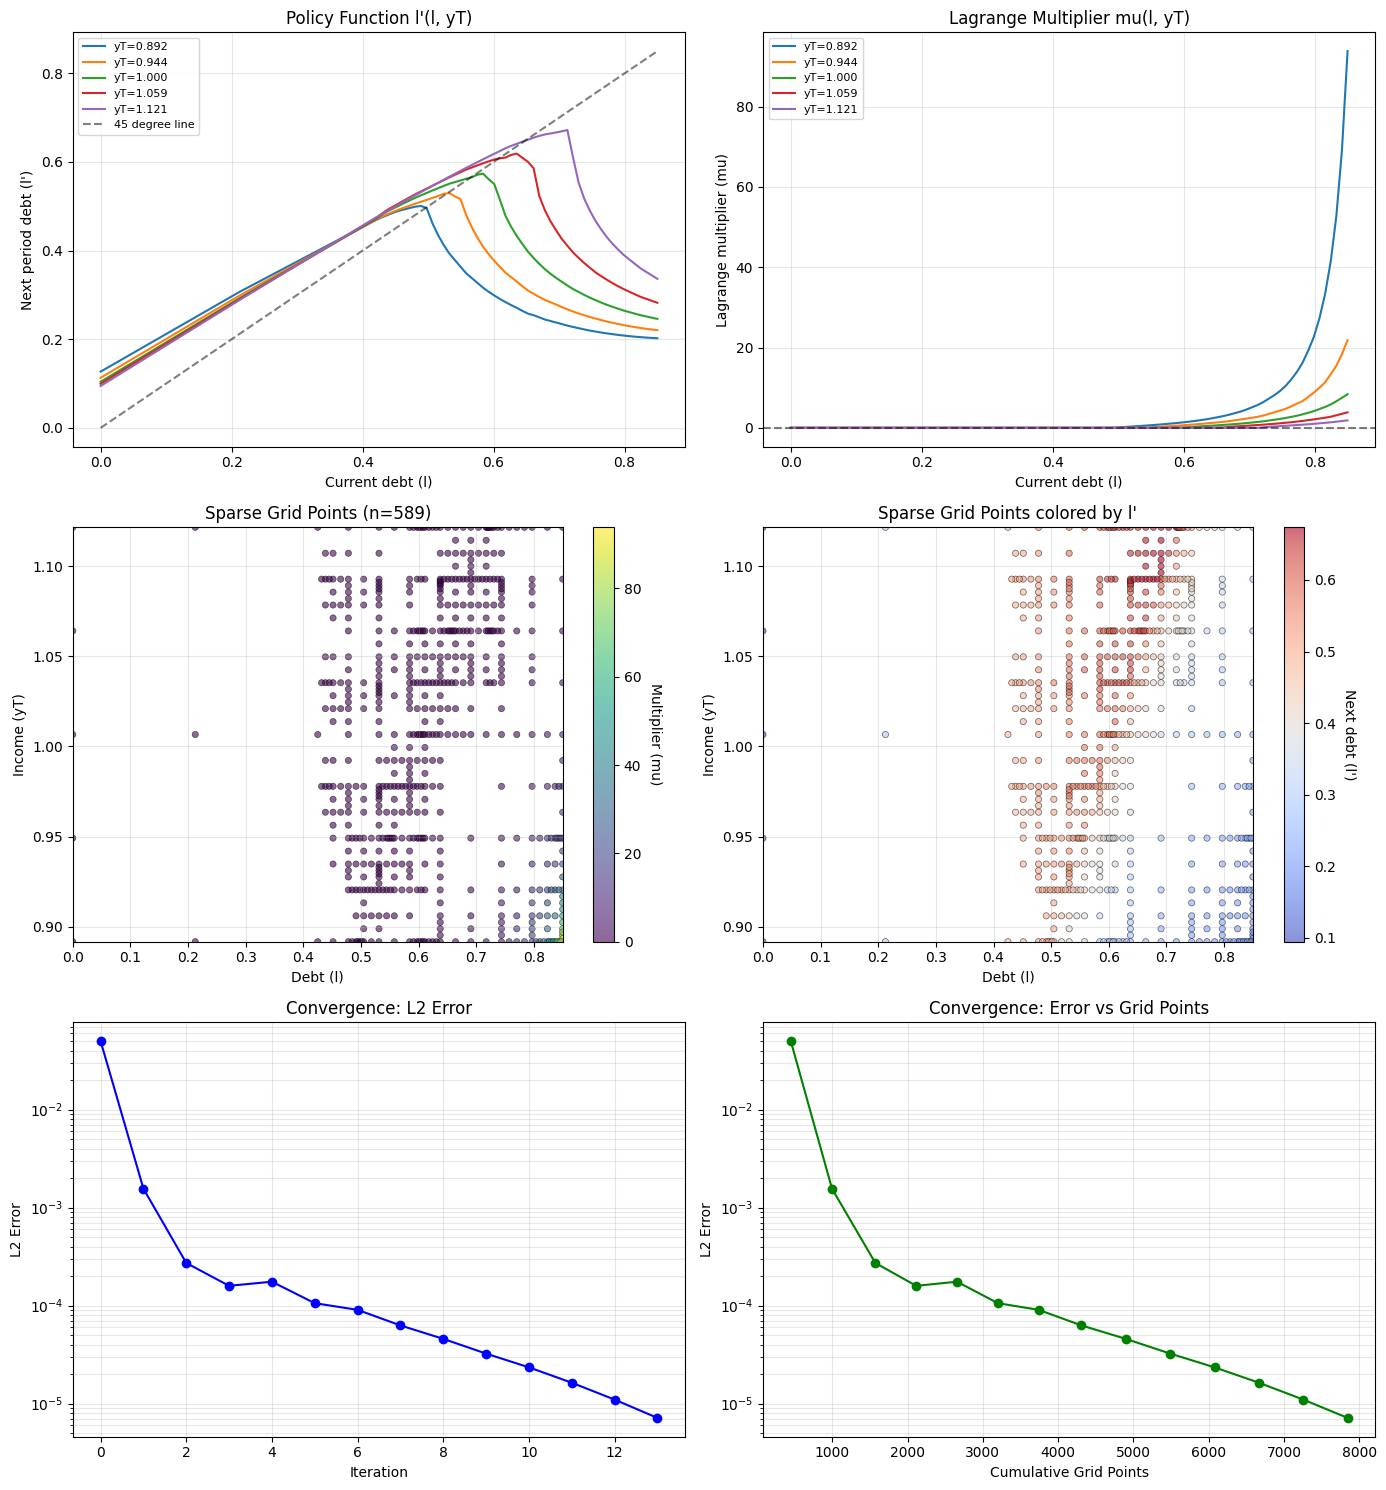


Summary Statistics
Metric                      Value
---------------------  ----------
Final grid points      589
Final L2 error           7.13e-06
Total iterations        14
Total time (s)          25.3
Avg time per iter (s)    1.81

Done!


In [7]:
if __name__ == "__main__":
    # Solve the model
    policy_final, model = solve_bianchi_ddsg()

    print("\n" + "="*80)
    print("Done!")
    print("="*80)

# %%
